In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import harmonypy
import pymn
import scrublet as scr
import gseapy as gp
from gseapy.plot import barplot, dotplot
import bottleneck
import pyreadr
from scipy.io import mmread
import scipy
from sklearn import preprocessing
import random as rd
import scib
from matplotlib_venn import venn2,venn2_circles,venn3
from pyscenic.export import export2loom, add_scenic_metadata
from sklearn.decomposition import NMF
from sklearn import metrics
import palettable
from pyscenic.rss import regulon_specificity_scores
import matplotlib.image as mpimg
import cosg as cosg

import matplotlib as mpl

from pyscenic.utils import modules_from_adjacencies
from IPython.display import display, Image

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/pyMetaNeighbor-0.1.0-py3.9.egg/pymn/trainModel.py:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/pyMetaNeighbor-0.1.0-py3.9.egg/pymn/trainModel.py:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?
Error: package or namespace load failed for 'methods' in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/public/home/guogjgroup/ggj/anaconda3/envs/R3.6/lib/R/library/methods/libs/methods.so':
  libR.so: cannot open shared object file: No such file or directory
During startup - Warning messages:
1: package 'methods' was built under R version 3.6.3 
2: package "methods" in options("defaultPackages") was not found 
3: package 'datasets' was built under R version 3.6.3 
4: package 'grDevices' was built under R version 3.6.3 
5: package 'graphics' was built under R version 3.6.3 
6: package 'methods' was built under

In [2]:
sc.set_figure_params(dpi = 200, color_map = 'viridis_r' )
sc.settings.verbosity = 2

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


# adata for Seurat (All Cell)

In [8]:
adata = sc.read('cnv_high_epi_harmony_anno_latest.h5ad')

adata_gene = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cancer_subtyppe_integration_latest/harmony_latest/all_theta_inner_removal6.h5ad')

adata = adata[:, adata_gene.var.index.tolist()]

del adata_gene

adata.write('all_cluster_marker/seurat_marker/dge_for_seurat_all_high_cell.h5ad')

adata.obs[['cancer_type', 'leiden', 'study_id']].to_csv('all_cluster_marker/seurat_marker/dge_for_seurat_all_high_cell.csv')

In [10]:
np.unique(adata.obs['study_id']).tolist()

['BRCA_p1',
 'BRCA_p3',
 'BRCA_p4',
 'COAD_p1',
 'COAD_p2',
 'ESCA_p1',
 'ESCA_p3',
 'HCC_p1',
 'HCC_p2',
 'HCC_p3',
 'HCC_p4',
 'HCC_p5',
 'ICC_p1',
 'ICC_p2',
 'ICC_p4',
 'LUAD_p1',
 'LUAD_p2',
 'LUAD_p3',
 'LUAD_p4',
 'LUAD_p5',
 'LUAD_p6',
 'LUAD_p7',
 'READ_p1',
 'STAD_p1']

# Marker List Generation

In [10]:
pts_cutoff = 0.25
p_cutoff = 0.01
#logFC_cutoff = 1
logFC_cutoff = 0.5
#pts_change_cutoff = 0.1
pts_change_cutoff = 0

each_seurat = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/all_cluster_marker/seurat_marker/all_high_cell/dge_for_seurat_all_high_cell_markers.csv', index_col=0)

each_seurat = each_seurat[each_seurat['pct.1'] > pts_cutoff]
each_seurat = each_seurat[each_seurat['p_val_adj'] < p_cutoff]
each_seurat = each_seurat[each_seurat['avg_log2FC'] > logFC_cutoff]

each_seurat['pts_change'] = each_seurat['pct.1'] - each_seurat['pct.2']
each_seurat = each_seurat[each_seurat['pts_change'] > pts_change_cutoff]

each_seurat.to_csv('cancer_subtype_marker_DEG/cancer_subtype_marker.csv')

each_seurat['cluster'].value_counts()

12    468
11    454
10    181
7     131
5      99
6      97
8      70
9      69
1      60
3      33
0      29
4      25
2      19
Name: cluster, dtype: int64

In [186]:
each_seurat = pd.read_csv('cancer_subtype_marker_DEG/cancer_subtype_marker.csv', index_col=0)
all_gene_biotype = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cnv_high_DEG/all_gene_biotype_latest.csv', index_col=0)
each_seurat.index = list(range(0, each_seurat.shape[0]))

for i in each_seurat.index.tolist():
    
    each_seurat.loc[i, 'biotype_detailed'] = all_gene_biotype.loc[each_seurat.loc[i, 'gene'], 'biotype_detailed']

each_seurat.to_csv('cancer_subtype_marker_DEG/cancer_subtype_marker.csv')

In [6]:
adata = sc.read('cnv_high_epi_harmony_anno_latest.h5ad')

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.scale(adata)

adata.obs['leiden'] = adata.obs['leiden'].astype(str)
adata.obs['cancer_type'] = adata.obs['cancer_type'].astype(str)
adata.obs['study_id'] = adata.obs['study_id'].astype(str)

adata.obs['leiden_cancer'] = adata.obs['leiden'] + '_' + adata.obs['cancer_type']

adata.obs['leiden_patient'] = adata.obs['leiden'] + '_' + adata.obs['study_id']

normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [19]:
each_seurat = pd.read_csv('cancer_subtype_marker_DEG/cancer_subtype_marker.csv', index_col=0)
        
marker_dict = {}
marker_dict_heatmap = {}

for each_cluster in list(range(0, 13)):
    
    marker_dict[str(each_cluster)] = each_seurat[each_seurat['cluster'] == each_cluster][:10]['gene'].tolist()
    marker_dict_heatmap[str(each_cluster)] = each_seurat[each_seurat['cluster'] == each_cluster][:30]['gene'].tolist()

In [7]:
marker_dict = {
    '0': ['CDH11', 'ST3GAL1', 'MCL1'],
    '1': ['NPSR1-AS1', 'EBNA1BP2', 'RP11-244M2.1'],
    '2': ['CCND1', 'RGS5', 'CTNND2'],
    '3': ['PLPPR1', 'ANKRD36C', 'TFPI'],
    '4': ['AC105402.4', 'MT-ND2', 'MT-CO1'],
    '5': ['DOCK10', 'FYN', 'PLA2G16'],
    '6': ['C2orf48', 'DIAPH3', 'ARHGAP11B'],
    '7': ['COL25A1', 'RIMKLB', 'POU6F2'],
    '8': ['SPTLC3', 'PPP1R1C', 'PARP9'],
    '9': ['C10orf90', 'SOX9-AS1', 'CSMD1'],
    '10': ['DNAH12', 'CFAP47', 'DNAH6'],
    '11': ['LIF', 'LAMC2', 'TGM2'],
    '12': ['SEMA3D', 'CLVS1', 'LINC00535']
}

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


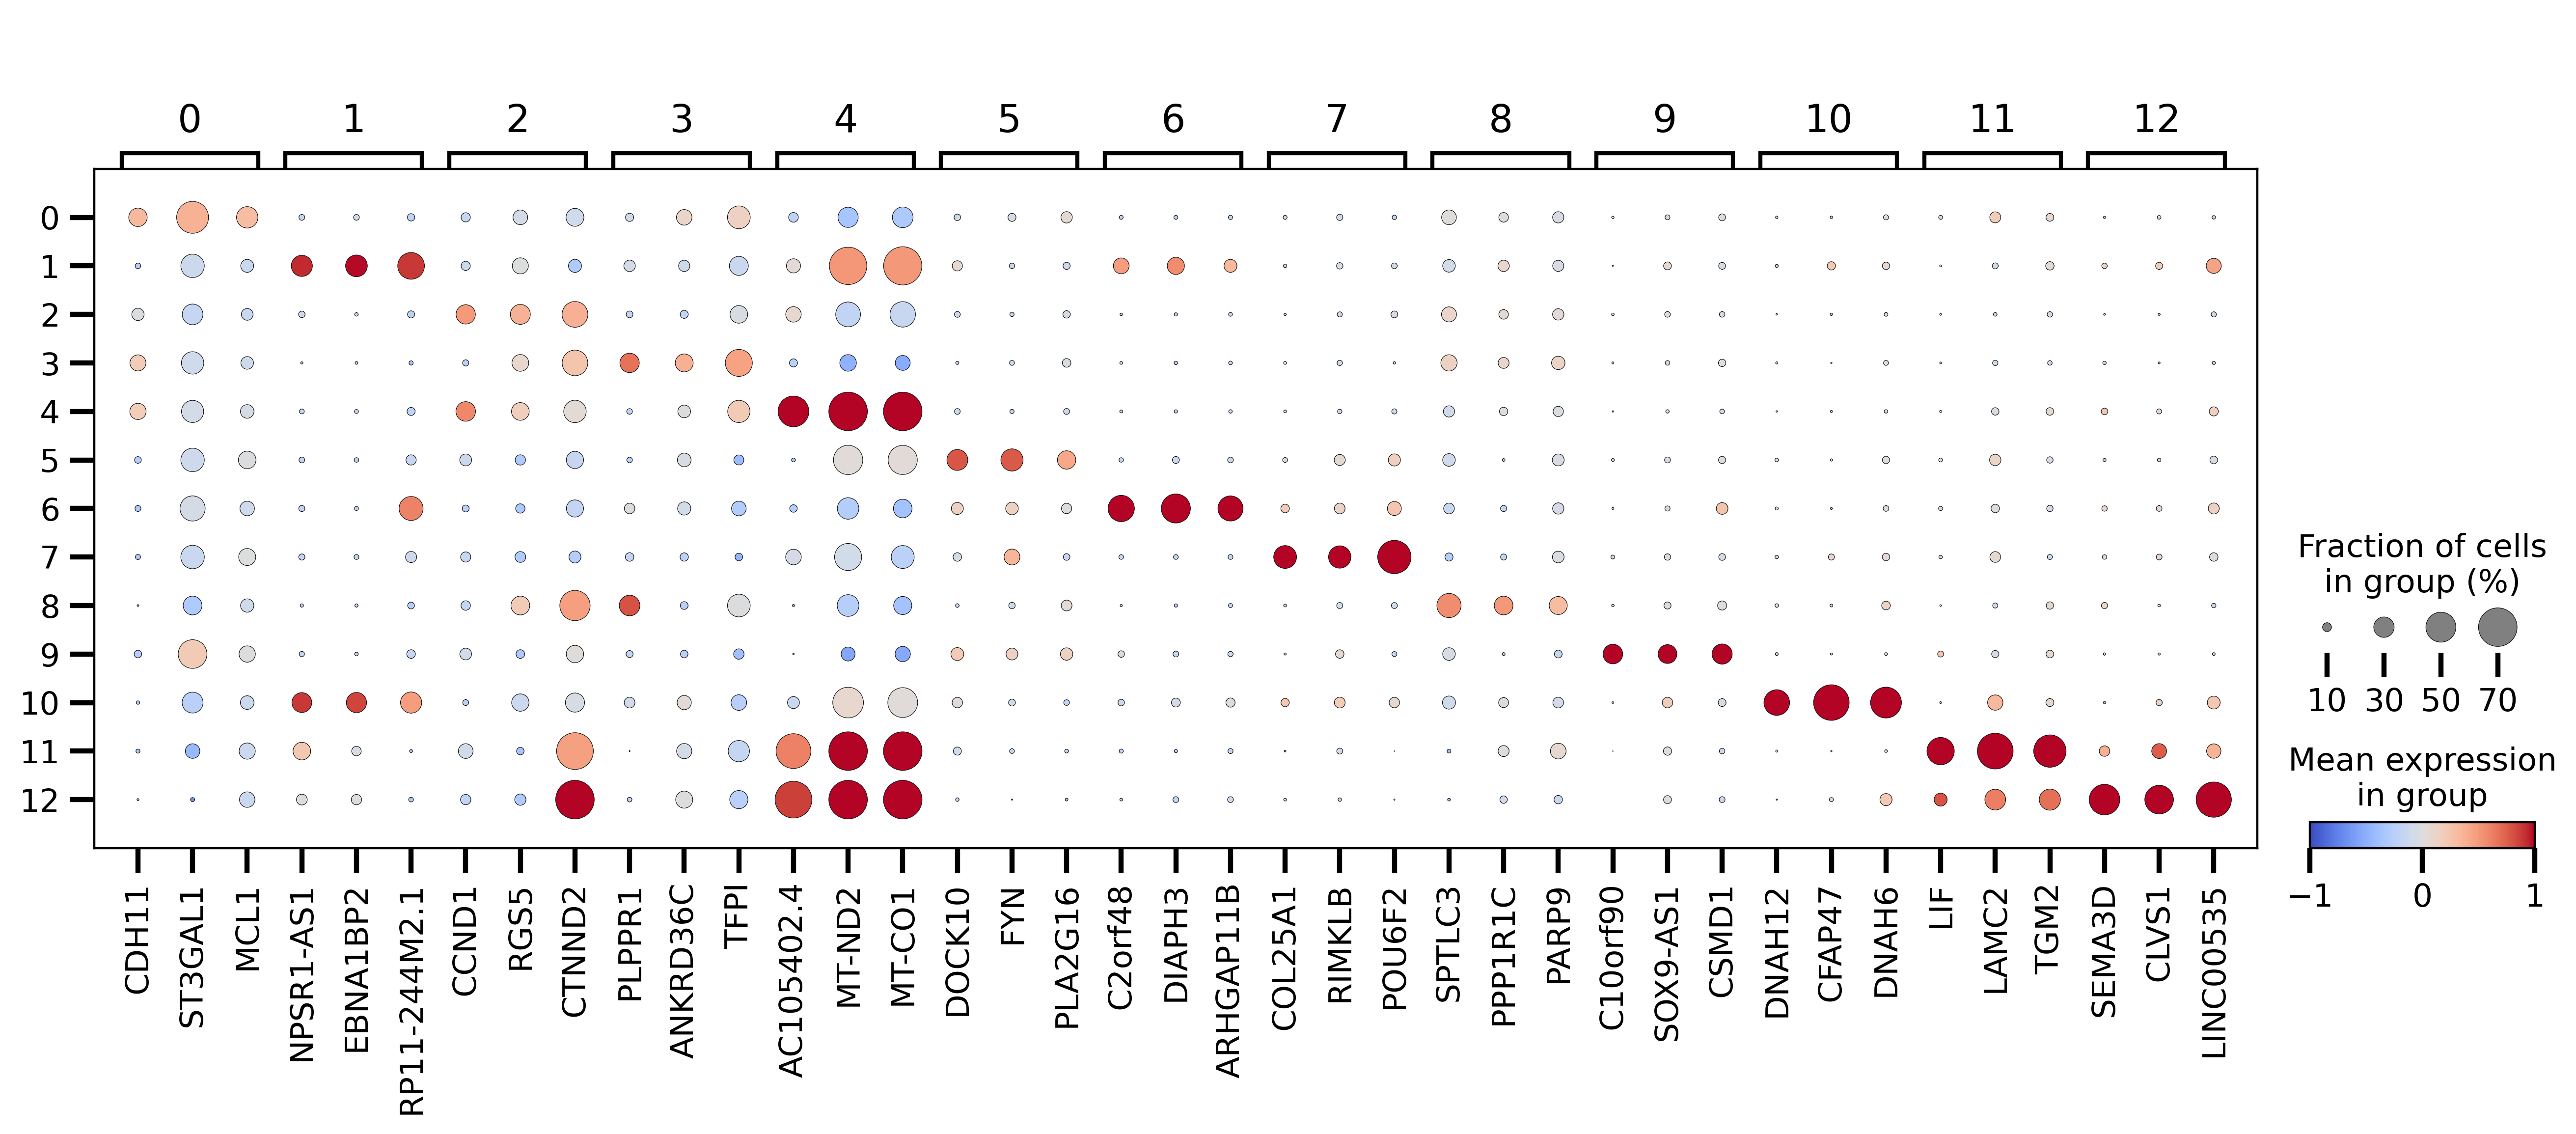

In [9]:
sc.pl.dotplot(adata, marker_dict, groupby='leiden', use_raw=False, 
              vmin=-1, vmax=1, cmap='coolwarm', dot_max=0.7, save='_cancer_subcluster_marker.pdf')